## Test the AtomSim class

In [1]:
# not all of these import necessary; many are for debugging
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from sympy import MatrixSymbol,MatMul,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import sympy as sp
from numpy import *
import time


# local imports
from physconsts import *
from rbconsts import *

# this is the class we're testing
from atomsim import AtomSim

### 3 level STIRAP - auto-generated ODE system

In [2]:
#### set up the simulation - this is the easiest way

rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

w = 10
dt = 20
t_exp = 120

t = symbols('t') # the time variable
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = Omax*e**(-((t+dt/2)/w)**2/2)
O1 = Omax* e**(-((t-dt/2)/w)**2/2)

D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = -D1 

H = hbar*Matrix([[0,   O1/2,  0],
                 [O1/2, -D1,  O2/2],
                 [0,   O2/2, -(D1+D2)]])

sim = AtomSim(rho0, t_exp, hamiltonian=H, 
              fields=[O1, O2])
for eq in sim.eqs:
    print(f'{eq} \n') # the equations generated if a hamiltonian is passed in

-9.48252172113838e+33*I*(1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*r01 - 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*conjugate(r01)) 

-9.48252172113838e+33*I*(-2.65042801565037e-35*r01 + 1.32521400782519e-34*2.71828182845905**(-(t/10 + 1.0)**2/2)*r02 + 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*r00 - 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*r11) 

-9.48252172113838e+33*I*(1.32521400782519e-34*2.71828182845905**(-(t/10 + 1.0)**2/2)*r01 - 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*r12) 

-9.48252172113838e+33*I*(1.32521400782519e-34*2.71828182845905**(-(t/10 + 1.0)**2/2)*r12 - 1.32521400782519e-34*2.71828182845905**(-(t/10 + 1.0)**2/2)*conjugate(r12) - 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*r01 + 1.32521400782519e-34*2.71828182845905**(-(t/10 - 1.0)**2/2)*conjugate(r01)) 

-9.48252172113838e+33*I*(2.65042801565037e-35*r12 + 1.32521400782519e-34*2.71828182845905**(-(t/10 + 1.0)**2/

Run time: 0.086 [s]


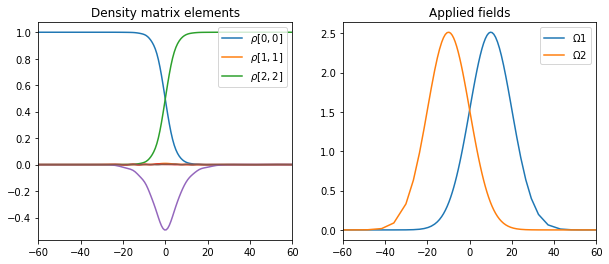

In [5]:
t0 = time.time()
rho, t = sim.runsim(tcentered=True)
print(f"Run time: {(time.time() - t0):.03f} [s]")
kwargs = {'figsize':(10,4)}
fig, axes = sim.plots(show=['populations','fields'], coherences=True,
                      plt_kwargs=kwargs)

In [7]:
sim.idx_p

[0, 3, 5]

### 3 level Coherent Rabi Oscillations with decay - auto-generated ODE system

In [6]:
## set up the simulation 
rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

t_exp = 40
w = 10
O1max = 2*pi
O2max = O1max
O2 = O2max # constant field intensity
O1 = O1max # constant field intensity
D1 = 10*O1max 
D2 = -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0

H = hbar*Matrix([[0,   O1/2,  0],
                 [O1/2, -D1,  O2/2],
                 [0,   O2/2, -(D1+D2)]])

G = hbar*Matrix([[.1, 0, 0], # not a realistic decay matrix, just a toy
                 [0, 0, 0],
                 [0, 0, 0]])

O = abs(O1max*O2max/(2*D1))/(2*pi)
print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} [arb]")
sim = AtomSim(rho0, t_exp, hamiltonian=H, decay=G)

Two-photon Rabi frequency = 2*pi*0.05 [arb]


In [7]:
t0 = time.time()
rho, t = sim.runsim(t_exp)
print(f"Run time: {time.time() - t0}")
kwargs = {'figsize':(10,4)}

Run time: 0.566511869430542


Text(0.5, 1.0, 'Three Level Rabi Flopping with Population Loss')

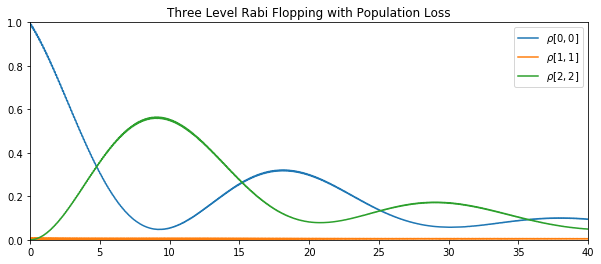

In [8]:
fig, axes = sim.plots(show=['populations'], coherences=False,
                      kwargs=kwargs)
ax = axes[0]
ax.set_ylim((0,1))
ax.set_title('Three Level Rabi Flopping with Population Loss')

### 3 level STIRAP example - hardcoded equations

In [11]:
#### hardcode the equations to be solved here

def derivs(y0,t,O1,O2,D1,D2):
    """
    Returns RHS of Von Neumann/Liouville eq for values at time t
    'y0': the unraveled non-redundant elements of the density matrix. e.g., 
        rho = [[r11,  r12,  r13], 
               [r12*, r22,  r23],
               [r13*, r23*, r33]] 
        ==> y0 = [r11, r12, r22, r23, r33]
    't': time
    'O1,2': field 1,2 Rabi frequency
    'D1,2': field 1,2 detuning
    """
    r11,r12,r13,r22,r23,r33 = y0 # 
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

In [12]:
## set up the simulation 
rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

w = 10
dt = 20
t_exp = 120
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

sim = AtomSim(rho0, t_exp, tcentered=True,  derivs=func, fields=[O1, O2])

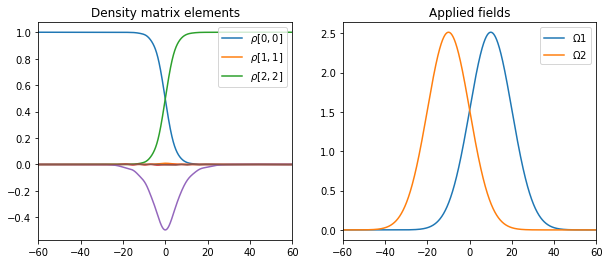

In [13]:
rho, t = sim.runsim()
kwargs = {'figsize':(10,4)}
fig, axes = sim.plots(show=['populations', 'fields'], coherences=True,
                      kwargs=kwargs)

### You don't have to use the built-in plot function; you can just plot the solutions like this:

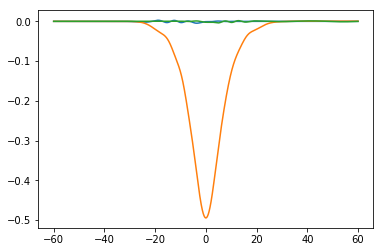

In [14]:
for c in sim.coherences:
    plt.plot(sim.t, real(c)) 
    # using numpy.real to remove imaginary part avoids
    # getting a warning message when matplotlib takes
    # the real part for you

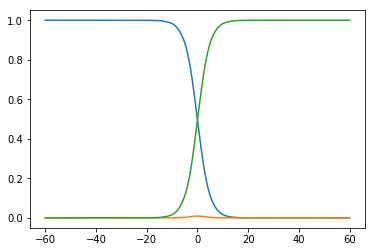

In [15]:
for p in sim.populations:
    plt.plot(sim.t, real(p)) # use numpy.real

## 3-lvl STIRAP - without the AtomSim class
the class is based on this code. 

In [16]:
#### functions 

def derivs(y0,t,O1,O2,D1,D2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    r11,r12,r13,r22,r23,r33 = y0
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

def runsim(func, idx=0, t_exp=60, tcentered=False):
    """ func is the derivs function
        idx is the index of the unraveled density matrix where 
            the population starts
        t_exp is experiment duration. t_2pi = 2*pi/w_rabi for 
            the simple three-level system
    """
    dt = 0.01 # timestep for DE solver
    t = arange(t_exp,step=dt)
    if tcentered == True:
        t -= t_exp/2
    tspan = [t[0],t[-1]]

    y0 = zeros(6, complex)
    y0[0] = 1 + 0j # all population in ground state rho11

    return solve_ivp(func,tspan,y0,t_eval=t)#linspace(0,t_exp,400))

# # the dressed states
# psi_1 = lambda

In [17]:
#### parameters for coherent |g> <--> |r> oscillation 
# w = 1 # doesn't matter here
# t2 = 1 # doesn't matter here
# t1 = t2 + 5 # doesn't matter here
# O2 = lambda t: 2*pi*1 #exp(-((t-t2)/w)**2/2) # arb units
# O1 = lambda t: 2*pi*1 #exp(-((t-t1)/w)**2/2)
# D1 = 2*pi*10 # arb units
# D2 = lambda t: -D1# + (O1(t)**2 - O2(t)**2)/4*D1

#### parameters for stirap
w = 10
dt = 20
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

In [18]:
# func = lambda y,t: derivs(t,y,O1(t),O2(t),D1,D2(t))
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

soln = runsim(func, t_exp=120, tcentered=True)

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


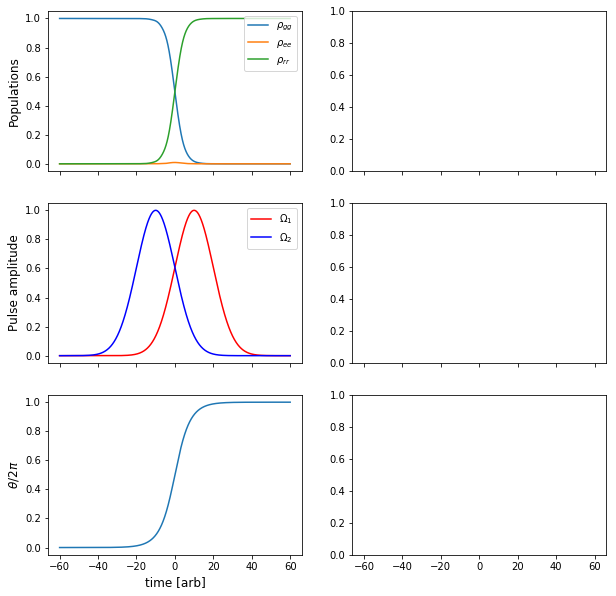

In [19]:
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex=True)
fntsize = 12
unit = 1 #2*pi # divide

# populations -- interaction basis {|g>,|e>,|r>}
# ax[0][0].set_title('Population evolution w/o spontaneous emission')
ax[0][0].set_ylabel('Populations', size=fntsize)
for i,l in zip([0,3,5],[r'$\rho_{gg}$',r'$\rho_{ee}$',r'$\rho_{rr}$']):
    ax[0][0].plot(soln.t/unit,soln.y[i],label=l)
ax[0][0].legend(loc='upper right')

# rabi frequency
ax[1][0].set_ylabel('Pulse amplitude', size=fntsize)
ax[1][0].plot(soln.t,O1(soln.t)/Omax,c='r',label=r'$\Omega_1$')
ax[1][0].plot(soln.t,O2(soln.t)/Omax,c='b',label=r'$\Omega_2$')
ax[1][0].legend(loc='upper right')

# mixing angle
ax[2][0].set_ylabel(r'$\theta / 2\pi$', size=fntsize)
ax[2][0].plot(soln.t, arctan(O1(soln.t)/O2(soln.t))/(pi/2))
ax[2][0].set_xlabel('time [arb]', size=fntsize)

# populations in dressed basis {|B+>,|D>,|B->}
# coherences
# for i,l in zip([1,2],[r'$\rho_{ge}$', r'$\rho_{gr}$']): ## this isn't correct
#     ax[0][1].plot(soln.t,soln.y[i], label=l)
# ax[0][1].set_ylim((0,1))
# ax[0][1].legend(loc='upper right')

# plot population in ee vs single pulse area? 

plt.show()